In [1]:
using Random
using Distributions
using LinearAlgebra
using ForwardDiff
include("../Inversion/Plot.jl")
include("../Inversion/GMNVI.jl")
include("../Inversion/DF_GMVI.jl")
include("../Inversion/GMBBVI.jl")

Gaussian_mixture_BBVI (generic function with 1 method)

## Gaussian function

Consider the following inverse problem 

$$
\begin{align*}
y = 
A\theta
+\eta
\qquad 
y = 
\begin{bmatrix}
y_{(1)}\\
y_{(2)}
\end{bmatrix}
\qquad
\Sigma_{\eta} = \sigma_\eta^2 I
\end{align*}
$$

We focus on the noninformative uniform prior, and hence we are sampling 
$e^{-\frac{1}{2\sigma_\eta^2} (y - A\theta)^T(y - A\theta) }$.

The posterior is a Gaussian with 
$$
m_{\rm post} = (A^TA)^{-1}A^T y  \qquad
C_{\rm post} = \sigma_\eta^2(A^TA)^{-1}
$$

## Logconcave likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\begin{bmatrix}
(\sqrt{\lambda}\theta_{(1)} -  \theta_{(2)})\\
\theta_{(2)}^2
\end{bmatrix}
+\eta
\qquad 
y = 
\begin{bmatrix}
y_{(1)}\\
y_{(2)}
\end{bmatrix}
\qquad
\Sigma_{\eta} = \sigma_{\eta}^2 I
\end{align*}
$$

We focus on the noninformative uniform prior, and hence we are sampling 
$e^{-\frac{1}{2\sigma_\eta^2}\bigl((y_{(1)} - \sqrt{\lambda}\theta_{(1)} + \theta_{(2)})^2 + (y_{(2)} - \theta_{(2)}^2)^2\bigr)}$.
     
     

In [2]:
function G(θ, arg, Gtype = "Gaussian")
    if Gtype == "Gaussian"
        A = arg
        return A*θ
    elseif Gtype == "Logconcave"
        λ = arg
        return [sqrt(λ)*θ[1] - θ[2]; θ[2]^2]
    else
        print("Error in function G")
    end
end


function F(θ, args)
    y, ση, A, Gtype = args
    Gθ = G(θ, A, Gtype )
    return [y[1] - Gθ[1]; y[2] - Gθ[2]]/ση
end


function logrho(θ, args)
    Fθ = F(θ, args)
    return -(Fθ[1]^2 + Fθ[2]^2)/2.0 
end


function dV(θ, args)
    return -logrho(θ, args), 
           -ForwardDiff.gradient(x -> logrho(x, args), θ), 
           -ForwardDiff.hessian(x -> logrho(x, args), θ)
end


function V(θ, args)
    return -logrho(θ, args)
end



V (generic function with 1 method)

In [3]:
function Gaussian_VI(func_dV, func_V, func_F, μ0, Σ0; N_iter = 100, dt = 1.0e-3)

    N_f = 2
    N_θ = length(μ0)

    T =  N_iter * dt
    N_modes = 1
    x0_w = ones(N_modes)
    x0_mean = reshape(μ0,1,N_θ)
    xx0_cov = reshape(Σ0,1,N_θ,N_θ)
    quadrature_type_GM = "mean_point"

    if func_dV !== nothing
        ngf_obj = GMNVI_Run(
        func_dV, 
        T,
        N_iter,
        # Initial condition
        x0_w, x0_mean, xx0_cov;
        diagonal_covariance = false,
        quadrature_type_GM = quadrature_type_GM,
        quadrature_type = "mean_point")

    end

    if func_F !== nothing
        dfgmvi_obj = DF_GMVI_Run(
        func_F, 
        T,
        N_iter,
        # Initial condition
        x0_w, x0_mean, xx0_cov;
        N_f = 2,
        quadrature_type_GM = quadrature_type_GM,
        quadrature_type = "unscented_transform")

    end
    
    if func_V !== nothing
        bbvi_obj = Gaussian_mixture_BBVI(
        func_V, 
        # Initial condition
        x0_w, x0_mean, xx0_cov;
        diagonal_covariance = false,
        discretize_inv_covariance = true,
        N_ens = 10,
        N_iter = N_iter)

    end


    return ngf_obj, dfgmvi_obj, bbvi_obj
end



Gaussian_VI (generic function with 1 method)

[ Info: ("iter = ", 10, " / ", 100)
[ Info: ("iter = ", 20, " / ", 100)
[ Info: ("iter = ", 30, " / ", 100)
[ Info: ("iter = ", 40, " / ", 100)
[ Info: ("iter = ", 50, " / ", 100)
[ Info: ("iter = ", 60, " / ", 100)
[ Info: ("iter = ", 70, " / ", 100)
[ Info: ("iter = ", 80, " / ", 100)
[ Info: ("iter = ", 90, " / ", 100)
[ Info: ("iter = ", 100, " / ", 100)
[ Info: ("iter = ", 10, " / ", 100)
[ Info: ("iter = ", 20, " / ", 100)
[ Info: ("iter = ", 30, " / ", 100)
[ Info: ("iter = ", 40, " / ", 100)
[ Info: ("iter = ", 50, " / ", 100)
[ Info: ("iter = ", 60, " / ", 100)
[ Info: ("iter = ", 70, " / ", 100)
[ Info: ("iter = ", 80, " / ", 100)
[ Info: ("iter = ", 90, " / ", 100)
[ Info: ("iter = ", 100, " / ", 100)
[ Info: ("iter = ", 10, " / ", 100)
[ Info: ("iter = ", 20, " / ", 100)
[ Info: ("iter = ", 30, " / ", 100)
[ Info: ("iter = ", 40, " / ", 100)
[ Info: ("iter = ", 50, " / ", 100)
[ Info: ("iter = ", 60, " / ", 100)
[ Info: ("iter = ", 70, " / ", 100)
[ Info: ("iter = ", 80, " 

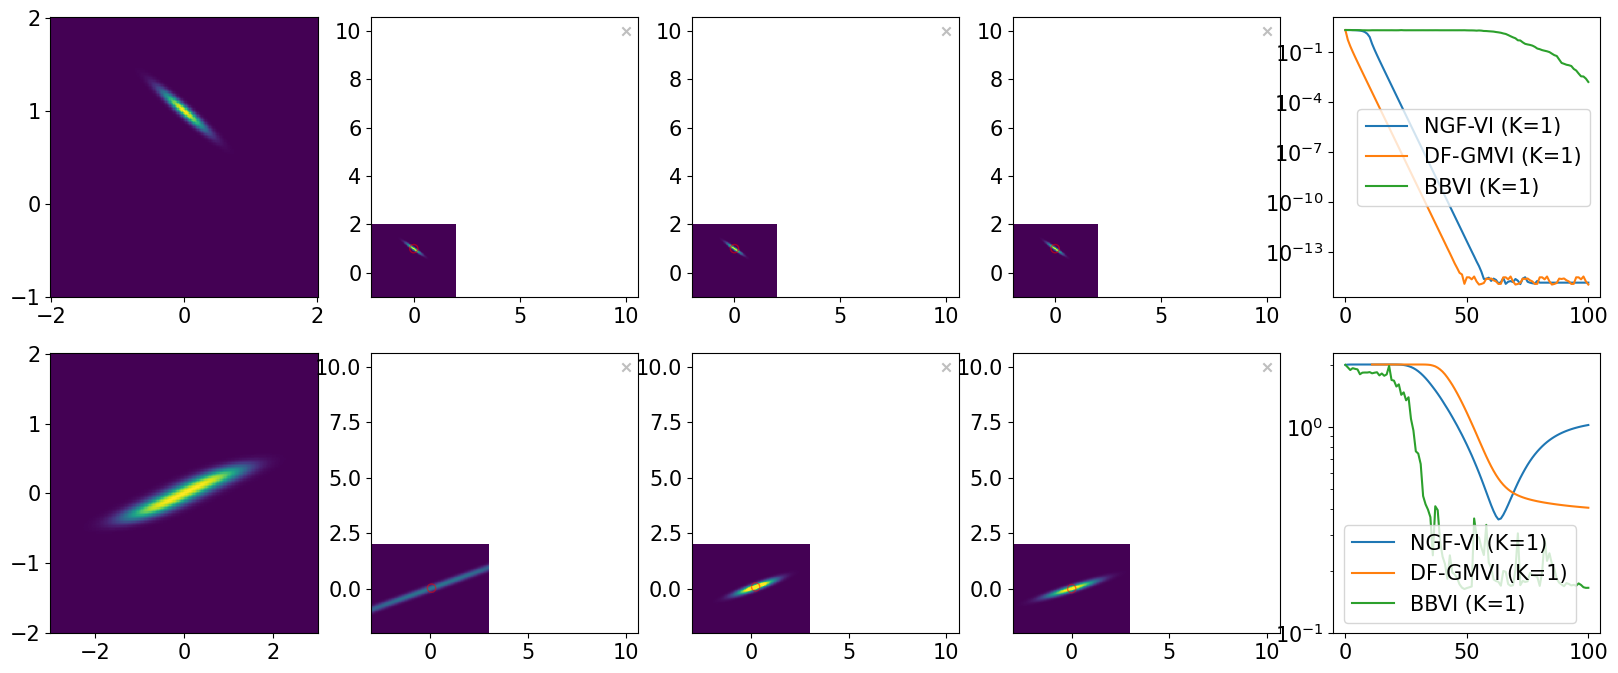

PyObject <matplotlib.legend.Legend object at 0x3471df3d0>

In [6]:
include("../Inversion/GMBBVI.jl")
fig, ax = PyPlot.subplots(nrows=2, ncols=5, sharex=false, sharey=false, figsize=(20,8))

Random.seed!(123)
μ0, Σ0 = [10.0; 10.0], [4.0 0.0; 0.0 4.0]
N_iter = 100


y = [1.0; 2.0]
ση = 0.1
Gtype = "Gaussian"
A = [1.0 1.0; 1.0 2.0]
C_post, m_post = ση^2*inv(A'*A), (A'*A)\(A*y)
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
func_V(x) = V(x, func_args)
func_dV(x) = dV(x, func_args)
ngf_obj, dfgmvi_obj, bbvi_obj = Gaussian_VI(func_dV, func_V, func_F, μ0, Σ0; N_iter = N_iter, dt = 5e-1)
objs = (ngf_obj, dfgmvi_obj, bbvi_obj);
visualization_2d(ax[1,:]; Nx=200, Ny=200, x_lim=[-2.0,2.0], y_lim=[-1.0,2.0], func_F=func_F, objs=objs, label=["NGF-VI", "DF-GMVI", "BBVI"])


y = [0.0; 0.0]
ση = 0.1
Gtype = "Logconcave"
λ = 0.1
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_V(x) = V(x, func_args)
func_dV(x) = dV(x, func_args)
ngf_obj, dfgmvi_obj, bbvi_obj = Gaussian_VI(func_dV, func_V, func_F, μ0, Σ0; N_iter = N_iter, dt = 2e-1)
objs = (ngf_obj, dfgmvi_obj, bbvi_obj);
visualization_2d(ax[2,:]; Nx=200, Ny=200, x_lim=[-3.0,3.0], y_lim=[-2.0,2.0], func_F=func_F, objs=objs, label=["NGF-VI", "DF-GMVI", "BBVI"])